<a href="https://colab.research.google.com/github/Bitang-Melyen-Tanulok/Csip_Csip/blob/main/Cross_valid_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
from google.colab import drive

X = []
Y = []
drive.mount('/content/drive')
path = '/content/drive/MyDrive/DeepLearning'

spectrograms_path = os.path.join(path, 'ugyanaz?')  # Path to folder with training data
folders = os.listdir(spectrograms_path)

for folder in folders:
    print(f"Current folder: {folder}")
    folder_path = os.path.join(spectrograms_path, folder)

    # Reading spectrogram files
    files = os.listdir(folder_path)

    for file in files:
        if file.endswith('.png'):  # Only reading PNGs
            file_path = os.path.join(folder_path, file)

            # Loading image
            img = image.load_img(file_path, color_mode='grayscale')
            img_array = image.img_to_array(img)  # Converting image into array
            X.append(img_array)

            # Adding label based on the folder name
            Y.append(folder)

X = np.array(X)
Y = np.array(Y)

# Print X and Y shape
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")

# Shuffle X and Y the same way
permutation = np.random.permutation(len(X))
X = X[permutation]
Y = Y[permutation]

Mounted at /content/drive
Current folder: blrwar1
Current folder: grenig1
Current folder: junmyn1
Current folder: pursun4
Current folder: revbul
Current folder: rutfly6
Current folder: barswa
Current folder: jerbus2
Current folder: insowl1
Current folder: lewduc1
Current folder: plaflo1
Current folder: putbab1
Current folder: redspu1
Current folder: rewlap1
Current folder: rufbab3
Current folder: sqtbul1
Current folder: vefnut1
Current folder: categr
Current folder: forwag1
Current folder: rerswa1
X shape: (2307, 128, 313, 1)
Y shape: (2307,)


Since this is a multi-class classification task, I am converting labels to one-hot format:

In [2]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

#First, the labels need to be converted into numerical values
le = LabelEncoder()
Y_encoded = le.fit_transform(Y)

#Getting number of classes
num_classes = len(le.classes_)
print(f"Class number= {num_classes}")

#Converting to one-hot encoding
Y_onehot = to_categorical(Y_encoded, num_classes)

Class number= 20


In [3]:
from tensorflow.keras.callbacks import EarlyStopping

#Implementing early stopping, since there is no reason for it to learn further when val_loss isn't decreasing
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, #If it doesn't improve for 5 epochs, it concludes
    verbose=1,
    restore_best_weights=True
)

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint

#Wanting to save the best model, so implementing checkpointing
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [5]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies = []
fold_losses = []

history_per_fold = []

# Start Stratified K-Fold cross-validation
fold_number = 1
for train_index, valid_index in skf.split(X, Y_encoded):
  print(f"Startung fold: {fold_number}")

  X_train, X_valid = X[train_index], X[valid_index]
  Y_train, Y_valid = Y_onehot[train_index], Y_onehot[valid_index]

  X_train = X_train / np.max(X_train)
  X_valid = X_valid / np.max(X_valid)

  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(num_classes, activation='softmax'))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  history = model.fit(
      X_train, Y_train,
      epochs=50,
      batch_size=32,
      validation_data=(X_valid, Y_valid),
      callbacks=[early_stopping, checkpoint],
      verbose=1
  )

  history_per_fold.append(history)

  valid_loss, valid_accuracy = model.evaluate(X_valid, Y_valid)

  fold_accuracies.append(valid_accuracy)
  fold_losses.append(valid_loss)

  fold_number += 1

model.summary()

Startung fold: 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2314 - loss: 2.6207
Epoch 1: val_loss improved from inf to 2.25367, saving model to best_model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.2317 - loss: 2.6188 - val_accuracy: 0.3268 - val_loss: 2.2537
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3803 - loss: 2.1520
Epoch 2: val_loss improved from 2.25367 to 1.94328, saving model to best_model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - accuracy: 0.3807 - loss: 2.1509 - val_accuracy: 0.4740 - val_loss: 1.9433
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4609 - loss: 1.7847
Epoch 3: val_loss improved from 1.94328 to 1.65341, saving model to best_model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step - accuracy: 0.4611 - loss: 1.7845 - val_accuracy: 0.5411 - val_loss: 1.6534
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5436 - loss: 1.5625
Epoch 4: val_loss improved from 1.65341 to 1.60684, saving model to b

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 126, 311, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 63, 155, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 61, 153, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 30, 76, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 28, 74, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 14, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 66304)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       8,487,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,746,878 (98.22 MB)

 Trainable params: 8,582,292 (32.74 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,164,586 (65.48 MB)

In [6]:
print("\nCross-Validation Results:")
print(f"Mean Validation Loss: {np.mean(fold_losses)}")
print(f"Mean Validation Accuracy: {np.mean(fold_accuracies)}")

for i, (loss, accuracy) in enumerate(zip(fold_losses, fold_accuracies), start=1):
    print(f"Fold {i} - Validation Loss: {loss}, Validation Accuracy: {accuracy}")


Cross-Validation Results:
Mean Validation Loss: 1.9171124935150146
Mean Validation Accuracy: 0.433876097202301
Fold 1 - Validation Loss: 1.4318263530731201, Validation Accuracy: 0.6038960814476013
Fold 2 - Validation Loss: 2.313861846923828, Validation Accuracy: 0.31168830394744873
Fold 3 - Validation Loss: 2.3405094146728516, Validation Accuracy: 0.2885032594203949
Fold 4 - Validation Loss: 2.288029193878174, Validation Accuracy: 0.31453362107276917
Fold 5 - Validation Loss: 1.2113356590270996, Validation Accuracy: 0.650759220123291


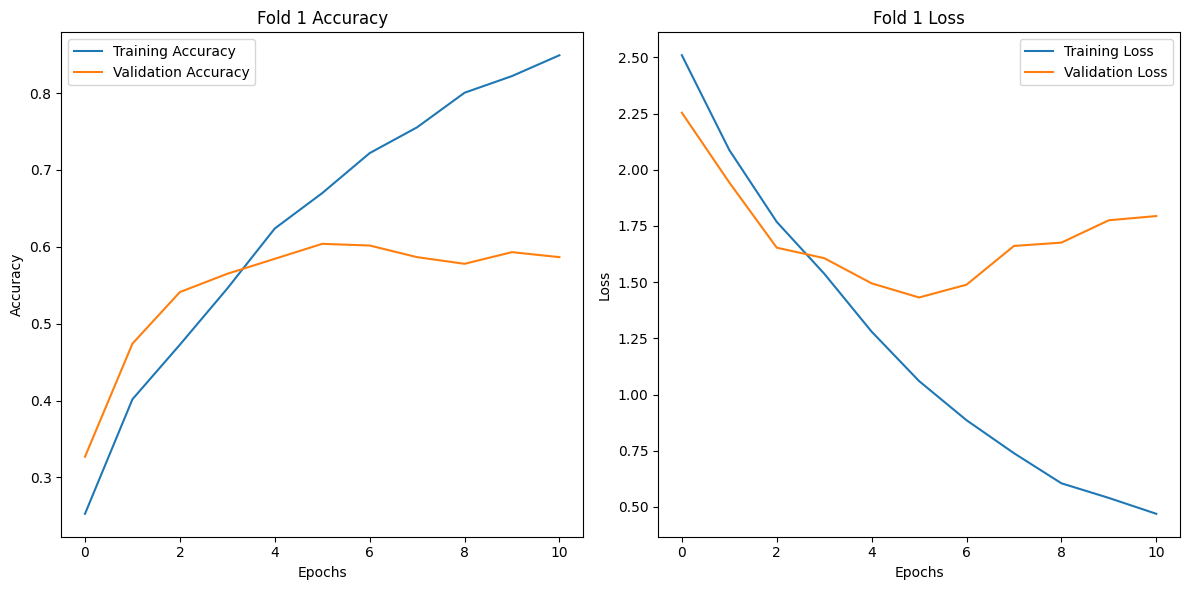

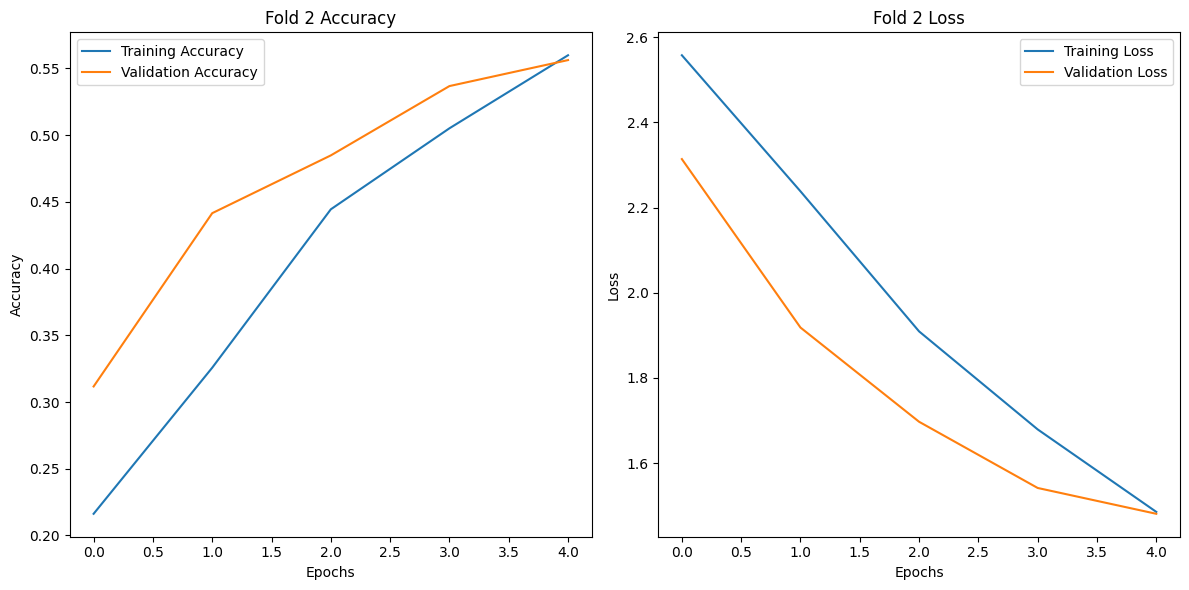

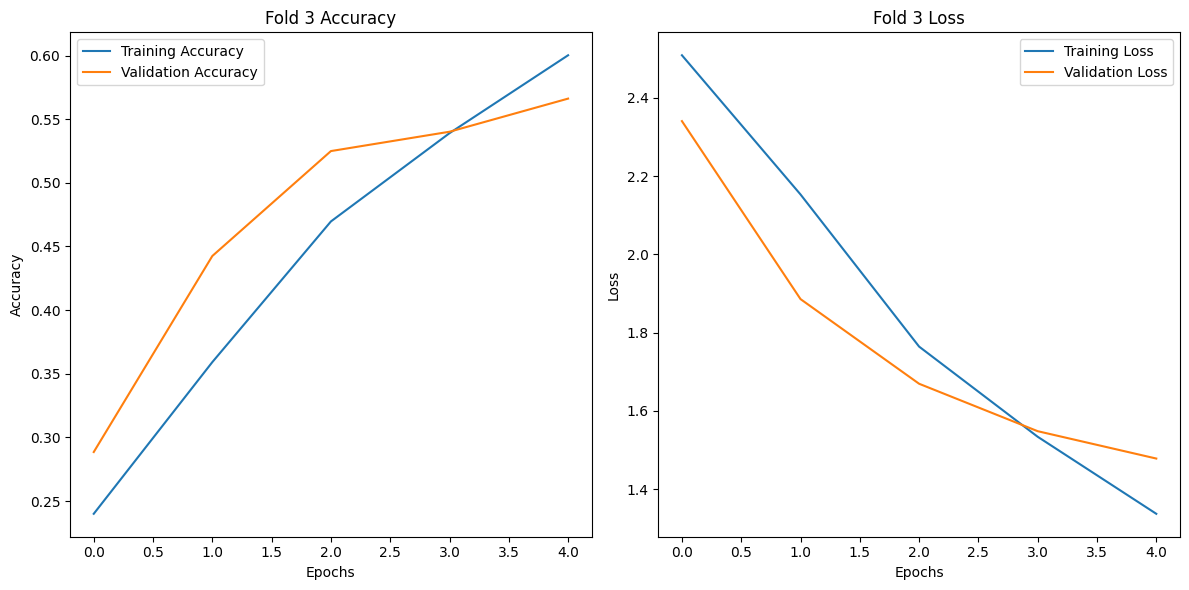

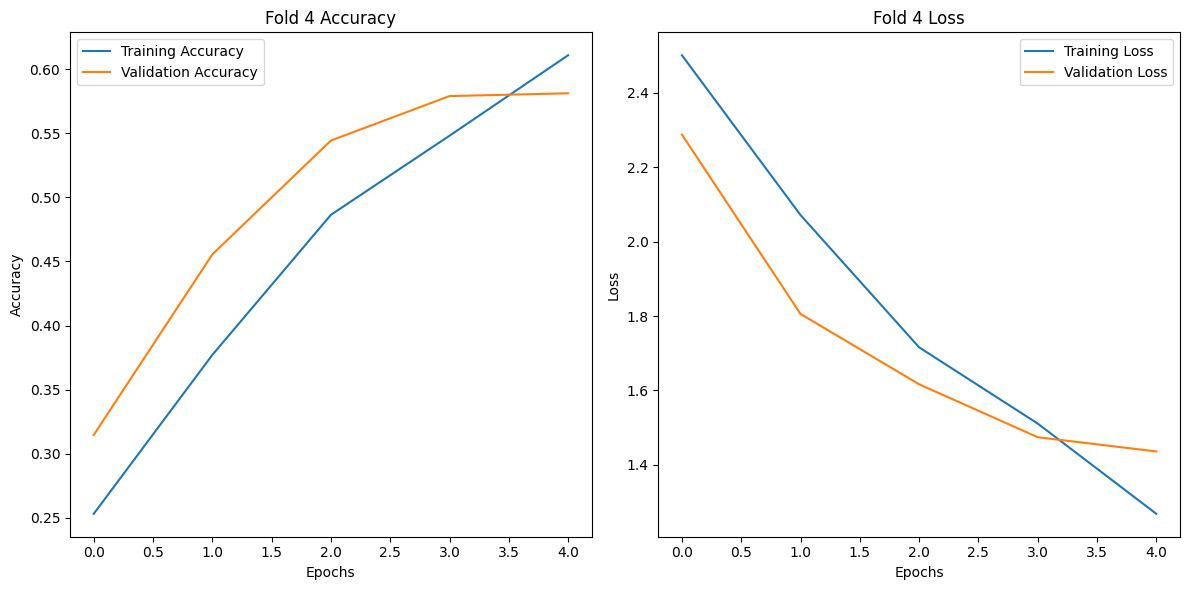

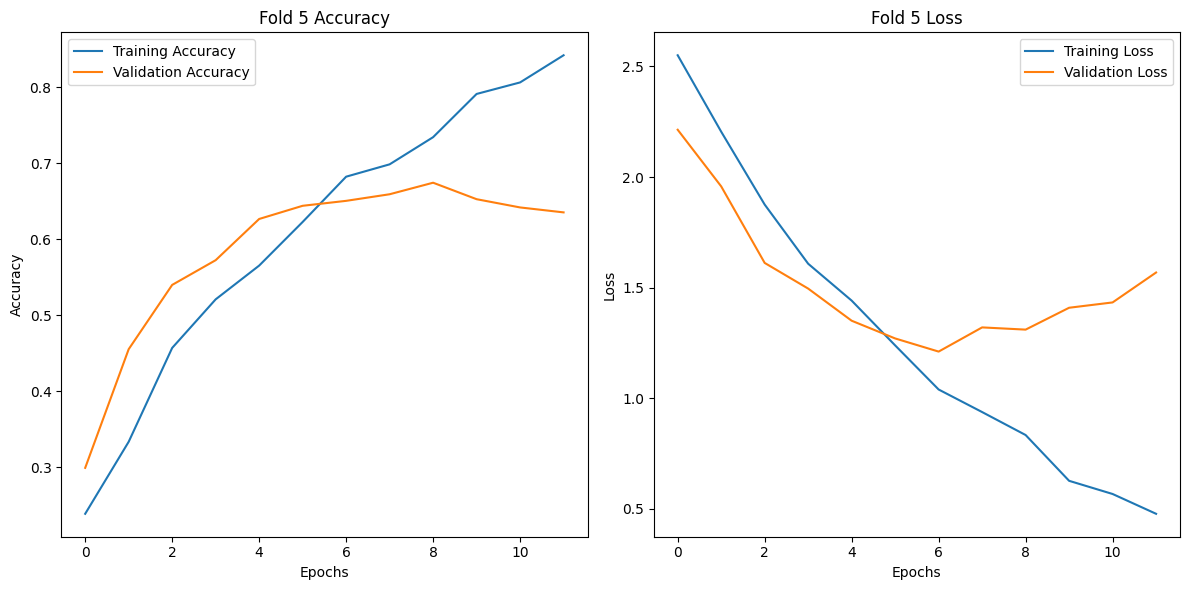

In [7]:
# Plot loss and accuracy for each fold
for i, history in enumerate(history_per_fold):
  plt.figure(figsize=(12, 6))

  # Plot accuracy
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title(f'Fold {i + 1} Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  # Plot loss
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title(f'Fold {i + 1} Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()